### __- Importation des librairies__

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

<br>

### __*- Prétraitement des données pour le COVID-19 X-ray dataset*__   
* __Redimensionner toutes les images à la même taille (ex. 128x128).__

* __Normaliser les pixels entre 0 et 1.__

* __Diviser les données : ( 80% → Entraînement,  20% → Validation,  10% → Test)__

<br>

__*1. Redimensionner toutes les images à la même taille (128 x 128)*__

In [2]:

# Paramètres
IMG_SIZE = 128
BATCH_SIZE = 16
data_dir = "data/xray_dataset_covid19"


# Charger le dataset train
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=123,
    shuffle=True
)

# Charger le dataset test
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=123
)


Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [3]:
# Compter le nombre total d'images dans train et test datasets
def count_images(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0] 
    return total

num_train = count_images(full_train_ds)
num_test = count_images(test_ds)

print(f"Images dans le dataset TRAIN : {num_train}")
print(f"Images dans le dataset TEST : {num_test}")


Images dans le dataset TRAIN : 148
Images dans le dataset TEST : 40


<br>


__*2. Normaliser les pixels entre 0 et 1*__

In [4]:
# Référence
     # https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
     # Transformer les pixels de [0, 255] → [0, 1]

# Normalisation des données d’entrée
normalization_layer = tf.keras.layers.Rescaling(1./255)
full_train_ds = full_train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

<br>


__*3. Je prends 80% du dataset train pour l’entrainement et 20% pour la validation et le test set contient 10 % de la train set.*__

In [30]:
'''Je prends 80% du dataset train pour l’entrainement et 20% pour la validation'''


AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000

full_train_ds = full_train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)


train_batches = tf.data.experimental.cardinality(full_train_ds).numpy()

# Calcul des parts : 80% train, 20% validation
val_batches = int(train_batches * 0.2)
train_batches = train_batches - val_batches

# Diviser le dataset train et validation
train_ds = full_train_ds.take(train_batches).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = full_train_ds.skip(train_batches).take(val_batches).cache().prefetch(buffer_size=AUTOTUNE)

print(f"✅ Train batches: {train_batches}, Validation batches: {val_batches}")
print(f"✅ Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")



✅ Train batches: 8, Validation batches: 2
✅ Test batches: 3


Affichage d'un batch de 16 images


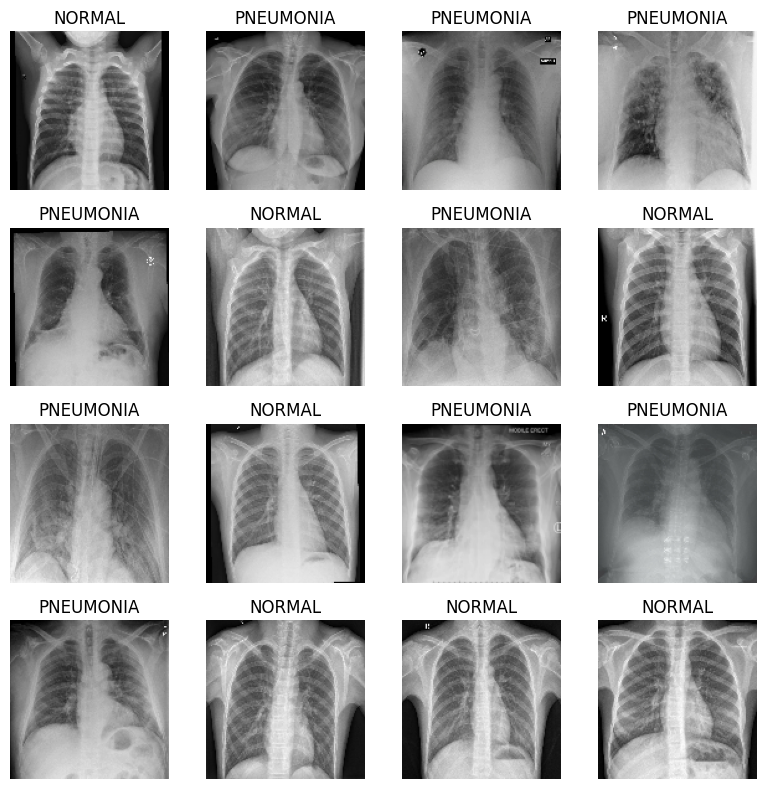

In [31]:
# Les notes :
    # index 0 : NORMAL
    # index 1 : PNEUMONIA



# Prendre un seul batch
for images, labels in train_ds.take(1):
    batch_size = images.shape[0]
    print(f"Affichage d'un batch de {batch_size} images")

    # Calculer le nombre de lignes et colonnes pour la grille
    cols = min(4, batch_size)
    rows = math.ceil(batch_size / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(batch_size):
        img = images[i].numpy()

        if img.min() < 0:
            img = (img + 1) / 2
        elif img.max() > 1.0:
            img = img / 255.0

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title("NORMAL" if labels[i] == 0 else "PNEUMONIA")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [39]:
for images, labels in train_ds.take(1):
    img = images[0].numpy()
    print("Valeurs min de l'image en pixels :", img.min())
    print("Valeurs max de l'image en pixels :", img.max())
    print("Type de données (dtype)        :", img.dtype)

Valeurs min de l'image en pixels : 0.0
Valeurs max de l'image en pixels : 0.9996583
Type de données (dtype)        : float32


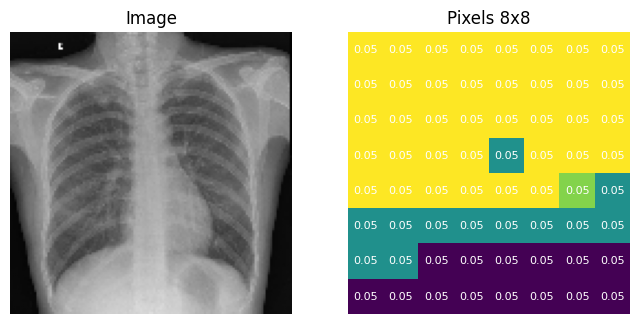

In [40]:
# Affiche une image et un extrait 8x8 pixels
for images, labels in train_ds.take(1):
    img = images[0].numpy()
    gray = img[:, :, 0] if img.ndim == 3 else img
    excerpt = gray[:8, :8]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(gray, cmap='gray'); ax1.set_title("Image"); ax1.axis("off")
    ax2.imshow(excerpt, cmap='viridis'); ax2.set_title("Pixels 8x8"); ax2.axis("off")

    for i in range(8):
        for j in range(8):
            ax2.text(j, i, f"{excerpt[i,j]:.2f}", ha='center', va='center', color='white', fontsize=8)

    plt.show()
    break


<br>
<br>


### __- Construction du modèle CNN__

In [ ]:
# Référence pour le modèle CNN
    # https://www.youtube.com/watch?v=jDe5BAsT2-Y
    # https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80
    # https://victorzhou.com/blog/intro-to-cnns-part-1/
    # https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175

# Padding images cnn
    # https://learnopencv.com/understanding-convolutional-neural-networks-cnn/
    # https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175



import keras
from keras.layers import Input

model = keras.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)), # 128x128x3 (taille de l'image en entrée) 

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
    # Plus de plusieurs classes : softmax au lieu de sigmoid
])



# Référence  (ADAM)
    # https://en.wikipedia.org/wiki/Stochastic_gradient_descent
    # https://datasciencewiki.net/adam-optimisation/


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 859,265 (3.28 MB)

 Trainable params: 859,265 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Entraînement (commence avec 7 époques)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    verbose=1
)

Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.5776 - loss: 0.6906 - val_accuracy: 0.7500 - val_loss: 0.6558
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6724 - loss: 0.6204 - val_accuracy: 0.7812 - val_loss: 0.5468
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8103 - loss: 0.4610 - val_accuracy: 0.7812 - val_loss: 0.3903
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8276 - loss: 0.4073 - val_accuracy: 1.0000 - val_loss: 0.1788
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9397 - loss: 0.2383 - val_accuracy: 0.9688 - val_loss: 0.1565
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9397 - loss: 0.1731 - val_accuracy: 0.9688 - val_loss: 0.0763
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9655 - loss: 0.1055 - val_accuracy: 1.0000 - val_loss: 0.0191


In [49]:
# Précision globale
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
train_loss, train_acc = model.evaluate(train_ds, verbose=0)

print(f"\n✅ Précision sur le test set : {test_acc:.2%}")
print(f"✅ Précision sur l'ensemble d'apprentissage : {train_acc:.2%}")

# Rapport détaillé
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(((preds > 0.5).astype(int).flatten()).tolist())
    y_true.extend(labels.numpy().astype(int).tolist())

print("\n📊 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))


✅ Précision sur le test set : 100.00%
✅ Précision sur l'ensemble d'apprentissage : 98.28%

📊 Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        20
   PNEUMONIA       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

